In [126]:
import cellular_automata as ca
import matplotlib.pyplot as plt
import numpy as np

In [127]:
def simulate_tumor_growth(time_delay, generations, rows, cols, phi, rho, k1, k2, k3, k4, cancer_init_positions, origin):
    history = {}
    M = ca.initialize_grid(rows, cols, cancer_init_positions)
    M_cluster = []

    for g in range(generations):
        M = ca.simulate_tumor_growth_one_step(M, g, time_delay, history, phi, rho, k1, k2, k3, k4, origin, rows, cols)

        M_cluster.append(M)

    return history, M_cluster




In [128]:
GENERATIONS = 500
ROWS = COLS = 101
ORIGIN = (COLS // 2, ROWS // 2)
PHI = 1000
CANCER_INIT_POSITIONS = [(ORIGIN[0], ORIGIN[1]), (ORIGIN[0] + 1, ORIGIN[1]), 
                         (ORIGIN[0] - 1, ORIGIN[1]), (ORIGIN[0], ORIGIN[1] - 1), 
                         (ORIGIN[0], ORIGIN[1] + 1)]
K1, K2, K3, K4 = 0.74, 0.2, 0.4, 0.4
RHO = 3.85

TIME_DELAY = 50
NO_TIME_DELAY = 0

In [129]:
def find_clusters(grid):
    visited = np.zeros_like(grid, dtype=bool)
    clusters = []

    for r in range(ROWS):
        for c in range(COLS):
            if grid[r, c] == 'C' and not visited[r, c]:
                cluster = set()
                stack = [(r, c)]

                while stack:
                    current_r, current_c = stack.pop()
                    if 0 <= current_r < ROWS and 0 <= current_c < COLS and grid[current_r, current_c] == 'C' and not visited[current_r, current_c]:
                        visited[current_r, current_c] = True
                        cluster.add((current_r, current_c))
                        stack.extend([(current_r + dr, current_c + dc) for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]])

                if cluster:
                    clusters.append(cluster)

    return clusters

In [148]:
history_no_delay, M_no_delay = simulate_tumor_growth(NO_TIME_DELAY, GENERATIONS, ROWS, COLS, PHI, RHO, K1, K2, K3, K4, CANCER_INIT_POSITIONS, ORIGIN)



In [131]:
# time delay = 7
history_delay, M_delay = simulate_tumor_growth(TIME_DELAY, GENERATIONS, ROWS, COLS, PHI, RHO, K1, K2, K3, K4, CANCER_INIT_POSITIONS, ORIGIN)

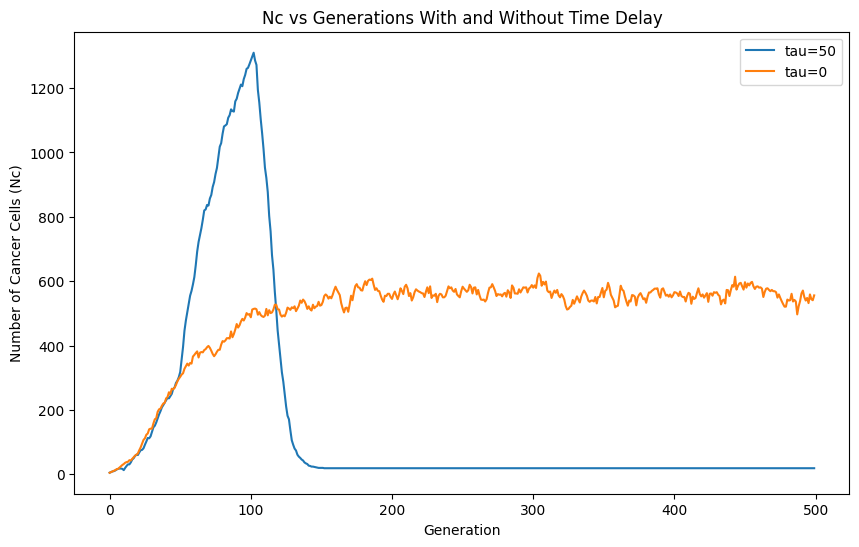

In [132]:
generations = list(range(GENERATIONS))
Nc_with_delay = [history_delay[g]['Nc'] for g in generations]
Nc_without_delay = [history_no_delay[g]['Nc'] for g in generations]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(generations, Nc_with_delay, label=f'tau={TIME_DELAY}')
plt.plot(generations, Nc_without_delay, label=f'tau={NO_TIME_DELAY}')
plt.xlabel('Generation')
plt.ylabel('Number of Cancer Cells (Nc)')
plt.title('Nc vs Generations With and Without Time Delay')
plt.legend()
plt.show()


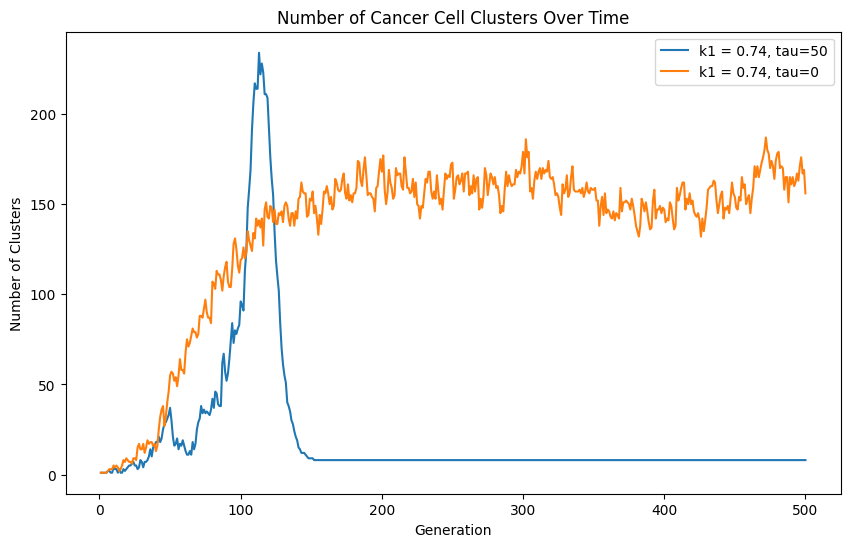

In [158]:


cluster_counts_k1_nodelay = []
cluster_counts_k1_delay = []

clusters_list_nodelay = []
for M in M_no_delay:
    clusters = find_clusters(M)
    clusters_list_nodelay.append(clusters)
    cluster_counts_k1_nodelay.append(len(clusters))


clusters_list_delay = []
for M in M_delay:
    clusters = find_clusters(M)
    clusters_list_delay.append(clusters)
    cluster_counts_k1_delay.append(len(clusters))

plt.figure(figsize=(10, 6))
plt.plot(range(1, GENERATIONS + 1), cluster_counts_k1_delay, label=f'k1 = 0.74, tau={TIME_DELAY}', linestyle='-')
plt.plot(range(1, GENERATIONS + 1), cluster_counts_k1_nodelay, label=f'k1 = 0.74, tau={NO_TIME_DELAY}', linestyle='-')
plt.title('Number of Cancer Cell Clusters Over Time')
plt.xlabel('Generation')
plt.ylabel('Number of Clusters')
plt.legend()
plt.show()

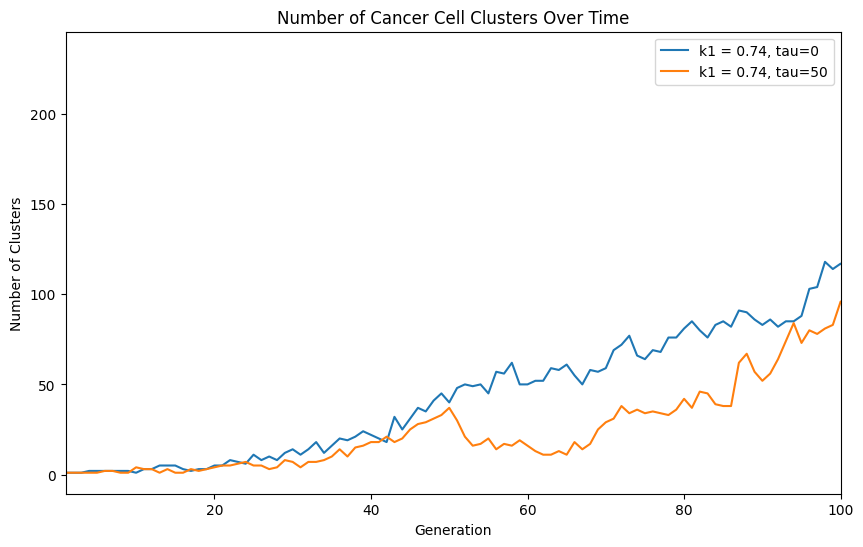

In [134]:

plt.figure(figsize=(10, 6))
plt.plot(range(1, GENERATIONS + 1), cluster_counts_k1_nodelay, label=f'k1 = 0.74, tau={NO_TIME_DELAY}', linestyle='-')
plt.plot(range(1, GENERATIONS + 1), cluster_counts_k1_delay, label=f'k1 = 0.74, tau={TIME_DELAY}', linestyle='-')
plt.title('Number of Cancer Cell Clusters Over Time')
plt.xlabel('Generation')
plt.ylabel('Number of Clusters')
plt.legend()

# Set x-axis limits to show only the first 100 generations
plt.xlim(1, 100)

plt.show()

In [164]:
# Average cluster size versus number of clusters

clusters_over_time = cluster_counts_k1_nodelay

# Split the array into subarrays based on the number of clusters
cluster_sizes = []
current_cluster = []

for value in clusters_over_time:
    current_cluster.append(value)
    if len(current_cluster) == value:
        cluster_sizes.append(current_cluster)
        current_cluster = []

# Calculate the average number of cancerous cells within each cluster size
average_cancer_cells_per_cluster = []

for cluster in cluster_sizes:
    average_cells = sum(cluster) / len(cluster)
    average_cancer_cells_per_cluster.append(average_cells)

# Print the results
for i, average_cells in enumerate(average_cancer_cells_per_cluster):
    print(f"Average Cancer Cells for Cluster Size {i + 1}: {average_cells}")









Average Cancer Cells for Cluster Size 1: 1.0
Average Cancer Cells for Cluster Size 2: 1.0
Average Cancer Cells for Cluster Size 3: 1.0
Average Cancer Cells for Cluster Size 4: 1.0
Average Cancer Cells for Cluster Size 5: 1.0
Average Cancer Cells for Cluster Size 6: 2.6666666666666665
Average Cancer Cells for Cluster Size 7: 12.222222222222221
Average Cancer Cells for Cluster Size 8: 126.51898734177215
Average Cancer Cells for Cluster Size 9: 160.42857142857142
